In [1]:
from dmeyf2025.modelling.train_model import train_models
from dmeyf2025.experiments.experiments import load_config
from dmeyf2025.etl import ETL
from dmeyf2025.processors.target_processor import BinaryTargetProcessor, CreateTargetProcessor
from dmeyf2025.processors.sampler import SamplerProcessor
from dmeyf2025.processors.feature_processors import DeltaLagTransformer
from dmeyf2025.metrics.revenue import lgb_gan_eval, revenue_from_prob
from run_experiment import get_features
import json
import os
import numpy as np
import lightgbm as lgb
import pandas as pd



/Users/frjofre/Documents/EyF/dmeyf2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
experiment_path = "experiments/delta-lags-percentile_0.1_150_01-04_G_Base_0.0.6"
#params = json.load(open(os.path.join(experiment_path, "best_params.json")))
config = load_config(os.path.join(experiment_path, "config.yaml"))



In [3]:
train_months = config["data"]["train_months"]
eval_month = config["data"]["eval_month"]
positive_class = config["experiment"]["positive_classes"]
seeds = config["experiment"]["seeds"]
data_path = config["experiment"]["raw_data_path"]
sample_ratio = config["experiment"]["sample_ratio"]
test_months = 202105


# Processing

In [13]:
etl = ETL(data_path, CreateTargetProcessor(),
train_months = [202101, 202102, 202103, 202104, 202105, 202106],)
X, y, _,_,_,_ = etl.execute_complete_pipeline()
target_processor = BinaryTargetProcessor(positive_class)
X, y = target_processor.fit_transform(X, y)

15:23:18 | INFO | Iniciando pipeline ETL completo...
15:23:22 | INFO | Archivo leído exitosamente: 978439 filas, 155 columnas
15:23:25 | INFO | Procesamiento completado: 978439 filas, 155 columnas
15:23:26 | INFO | DataFrame train: 978439
15:23:26 | INFO | Pipeline ETL completado exitosamente!


In [21]:
X["target"] = y
X_transformed = get_features(X)
X_transformed.set_index("numero_de_cliente", inplace=True)


In [25]:
X_transformed["target"]

numero_de_cliente
249221323     0
249227600     0
249234235     0
249244449     0
249244739     0
             ..
1598368433    0
1598419415    0
1598425905    0
1598470389    0
1598550167    0
Name: target, Length: 978439, dtype: int64

In [22]:
X_train = X_transformed[X_transformed["foto_mes"].isin(train_months)]
X_eval = X_transformed[X_transformed["foto_mes"].isin([eval_month])]
X_test = X_transformed[X_transformed["foto_mes"].isin([202105])] # Solo para ver el escalado

In [26]:
y_train = X_train["target"]
X_train = X_train.drop(columns=["target"])

In [29]:
X_train.shape

(650209, 786)

In [27]:
sampler_processor = SamplerProcessor(0.1)
X_train_sampled, y_train_sampled = sampler_processor.fit_transform(X_train, y_train)

15:29:22 | INFO | ✅ Dataset final: 71667 registros
15:29:22 | INFO |    - Clase positiva: 7385
15:29:22 | INFO |    - Clase negativa: 64282


In [28]:
X_train_sampled.shape

(71667, 786)

In [8]:
X_transformed.set_index("numero_de_cliente", inplace=True)
X_transformed.loc[:, "label"] = y


/var/folders/rc/prpxq6zd0654fg2rm3jwwx8h0000gp/T/ipykernel_47879/1619427130.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_transformed.loc[:, "label"] = y


In [9]:
X_train = X_transformed[X_transformed["foto_mes"].isin(train_months)]
y_train = X_train["label"]
X_train = X_train.drop(columns=["label"])
X_eval = X_transformed[X_transformed["foto_mes"].isin([eval_month])]
X_eval = X_eval.drop(columns=["label"])
X_test = X_transformed[X_transformed["foto_mes"].isin([202105])] # Solo para ver el escalado


# Train

In [10]:
preds, models= train_models(X_train, y_train, X_eval, params, seeds, experiment_path)

# Features

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

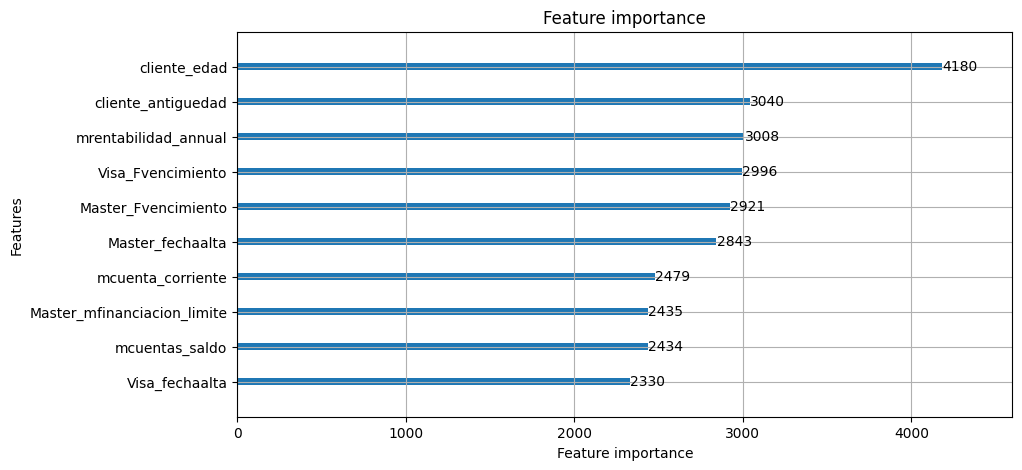

In [24]:
model  = models[0]
lgb.plot_importance(model, importance_type="split", max_num_features=10, figsize=(10, 5))


In [39]:
importances = pd.DataFrame()
importances["feature"] = X_train.columns
for n, model in enumerate(models):
    importances[f"importance_{n}"] = model.feature_importance(importance_type="gain")

In [41]:
importances["importance_mean"] = importances.drop(columns=["feature"]).mean(axis=1)
importances.sort_values(by="importance_mean", ascending=False, inplace=True)
importances.head(20)

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance_mean
106,ctrx_quarter,406083.784024,400763.957397,417159.349328,367015.132204,433217.271120,404847.898815
10,mpasivos_margen,86342.552867,86663.308896,79721.651296,96387.043661,80293.101643,85881.531673
50,cpayroll_trx,87181.161612,80922.621375,71011.031260,82760.060792,79646.681453,80304.311299
21,mcuentas_saldo,66851.319535,62634.921742,59330.204717,49816.617239,69955.570861,61717.726819
32,mprestamos_personales,64445.175852,58932.174345,64779.289887,56397.250846,62703.837027,61451.545591
51,mpayroll,52837.956673,58800.010352,65201.103436,58852.450547,53747.230218,57887.750245
17,mcaja_ahorro,44359.649628,52164.749289,45247.882357,54454.443749,41569.538317,47559.252668
251,ctrx_quarter_lag1,54574.483873,51065.036211,48789.290081,33365.244937,39109.527520,45380.716524
27,mtarjeta_visa_consumo,28656.159933,35554.148221,30417.980527,42108.724477,30461.913827,33439.785397
4,cliente_edad,32330.525962,33184.156214,31170.989710,33994.297160,32373.551349,32610.704079


# Predict

In [ ]:
import numpy as np
ones = np.ones(10000, dtype=int)
zeros = np.zeros(len(preds)-10000, dtype=int)
predictions = np.concatenate([ones, zeros])

In [ ]:
ones = np.ones(10000, dtype=int)
zeros = np.zeros(len(preds)-10000, dtype=int)
predictions = np.concatenate([ones, zeros])
preds["predicted"] = predictions
preds[["numero_de_cliente", "predicted"]].to_csv(f"{experiment_path}/DeltaLags2_0.3_150_01-04_G_0.0.2_ensemble_10k_predictions.csv", index=False)